In [1]:
import torch

In [2]:
# Load the trained probe model
probe_weights = torch.load("/workspace/llm-progress-monitor/rollouts-big/probe_weights.pt")

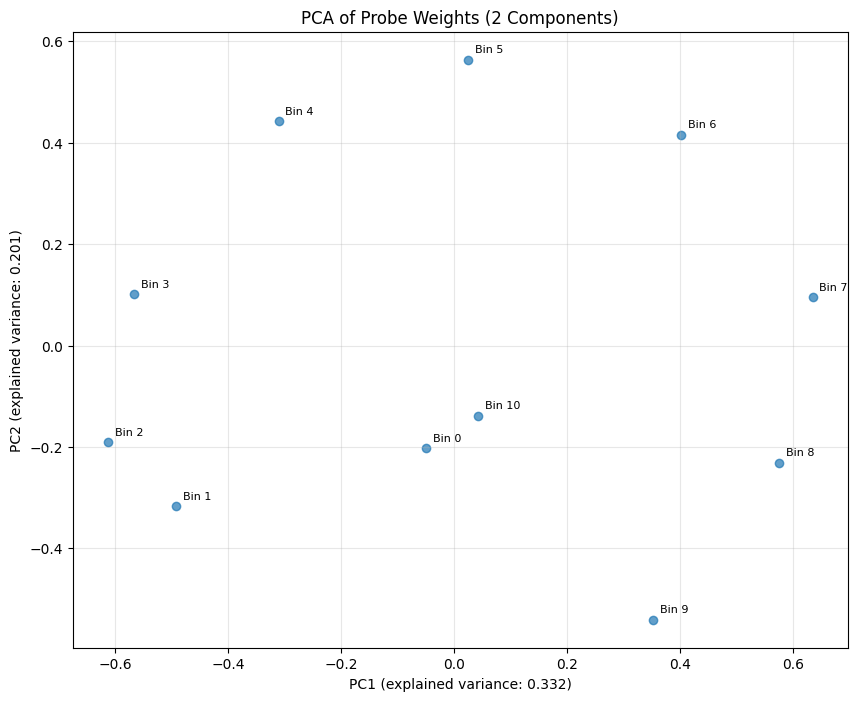

Total explained variance: 0.533


In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Perform PCA with 2 components
pca = PCA(n_components=2)
probe_weights_2d = pca.fit_transform(probe_weights.float().detach().cpu().numpy())

# Plot the PCA results
plt.figure(figsize=(10, 8))
plt.scatter(probe_weights_2d[:, 0], probe_weights_2d[:, 1], alpha=0.7)
plt.xlabel(f'PC1 (explained variance: {pca.explained_variance_ratio_[0]:.3f})')
plt.ylabel(f'PC2 (explained variance: {pca.explained_variance_ratio_[1]:.3f})')
plt.title('PCA of Probe Weights (2 Components)')
plt.grid(True, alpha=0.3)

# Add labels for each point (bin index)
for i, (x, y) in enumerate(probe_weights_2d):
    plt.annotate(f'Bin {i}', (x, y), xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.show()

print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.3f}")

In [4]:
from pipeline.load_activations import prepare_dataloaders

In [5]:
train_dataloader, test_dataloader, stats = prepare_dataloaders(
        activations_dir="/workspace/llm-progress-monitor/rollouts-big/activations",
        batch_size=1024,
        test_size=0.2,
        end_idx = 750
    )

2025-10-04 12:43:26,397 - INFO - Loading activations from: /workspace/llm-progress-monitor/rollouts-big/activations
2025-10-04 12:43:26,399 - INFO - Loading activations from index 0 to 750
2025-10-04 12:43:30,181 - INFO - Loaded 100 activations
2025-10-04 12:43:35,102 - INFO - Loaded 200 activations
2025-10-04 12:43:40,656 - INFO - Loaded 300 activations
2025-10-04 12:43:45,571 - INFO - Loaded 400 activations
2025-10-04 12:43:51,373 - INFO - Loaded 500 activations
2025-10-04 12:43:55,556 - INFO - Loaded 600 activations
2025-10-04 12:44:00,908 - INFO - Loaded 700 activations
2025-10-04 12:44:03,495 - INFO - Successfully loaded 750 activations
2025-10-04 12:44:03,499 - INFO - Split into 600 train and 150 test sequences
2025-10-04 12:44:07,059 - INFO - Created dataset with 523988 samples
2025-10-04 12:44:08,018 - INFO - Created dataset with 145864 samples
2025-10-04 12:44:08,020 - INFO - Created dataloaders - Train samples: 523988, Test samples: 145864


Original samples: 102400
After filtering outliers: 100352
Total explained variance (first 10 components): 0.175
Activations shape: (102400, 2560)
N_remaining shape: (102400,)
Binned values range: 0 to 10


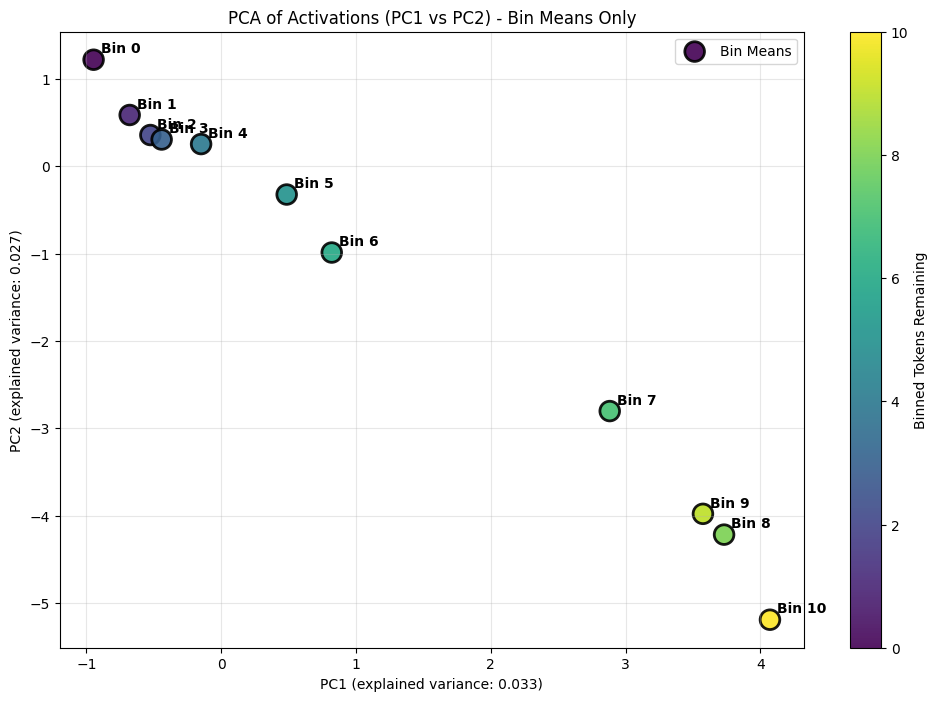

PC1 explained variance: 0.033
PC2 explained variance: 0.027
Number of bins with data: 11


In [10]:
# Perform PCA on activations - concatenate first 10 batches
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch

# Collect first 10 batches and compute PCA once
all_activations = []
all_n_remaining = []

for i, (activations, n_remaining, _) in enumerate(train_dataloader):
    if i >= 100:
        break
    all_activations.append(activations.float().detach().cpu().numpy())
    all_n_remaining.append(n_remaining.float().detach().cpu().numpy())

# Concatenate all batches
activations_np = np.concatenate(all_activations, axis=0)
n_remaining_np = np.concatenate(all_n_remaining, axis=0)

# Remove outliers - filter out 98th percentile based on activation magnitude
activation_magnitudes = np.linalg.norm(activations_np, axis=1)
percentile_98 = np.percentile(activation_magnitudes, 98)
mask = activation_magnitudes <= percentile_98

# Filter both activations and n_remaining
activations_filtered = activations_np[mask]
n_remaining_filtered = n_remaining_np[mask]

print(f"Original samples: {len(activations_np)}")
print(f"After filtering outliers: {len(activations_filtered)}")

# Bin the n_remaining values using the bin_y function
n_bins = 12
def bin_y(y):
    return ((y+1).log() / torch.log(torch.tensor(1.6)) - 10).floor().clamp(0,n_bins-1).to('cuda', dtype=torch.long)

# Convert n_remaining to tensor and bin it
n_remaining_tensor = torch.tensor(n_remaining_filtered)
n_remaining_binned = bin_y(n_remaining_tensor).cpu().numpy()

# Perform PCA once with 10 components
n_components = 10
pca = PCA(n_components=n_components)
activations_pca = pca.fit_transform(activations_filtered)

print(f"Total explained variance (first {n_components} components): {pca.explained_variance_ratio_.sum():.3f}")
print(f"Activations shape: {activations_np.shape}")
print(f"N_remaining shape: {n_remaining_np.shape}")
print(f"Binned values range: {n_remaining_binned.min()} to {n_remaining_binned.max()}")

def plot_pca_components(pc1=0, pc2=1):
    """
    Plot PCA of activations with specified principal components.
    Uses pre-computed PCA results for efficiency.
    
    Args:
        pc1: Index of first principal component to plot (default: 0)
        pc2: Index of second principal component to plot (default: 1)
    """
    # Extract the specified components
    activations_2d = activations_pca[:, [pc1, pc2]]

    # Calculate mean activations for each bin
    bin_means = []
    bin_centers = []
    for bin_idx in range(n_bins):
        mask_bin = n_remaining_binned == bin_idx
        if np.sum(mask_bin) > 0:
            bin_mean = np.mean(activations_2d[mask_bin], axis=0)
            bin_means.append(bin_mean)
            bin_centers.append(bin_idx)

    bin_means = np.array(bin_means)

    # Plot only the bin means
    plt.figure(figsize=(12, 8))
    
    if len(bin_means) > 0:
        scatter = plt.scatter(bin_means[:, 0], bin_means[:, 1], 
                   c=bin_centers, cmap='viridis', s=200, 
                   edgecolors='black', linewidth=2, alpha=0.9,
                   label='Bin Means')
        
        # Add labels for each bin mean
        for i, (x, y) in enumerate(bin_means):
            plt.annotate(f'Bin {bin_centers[i]}', (x, y), 
                        xytext=(5, 5), textcoords='offset points', 
                        fontsize=10, fontweight='bold')

        plt.colorbar(scatter, label='Binned Tokens Remaining')

    plt.xlabel(f'PC{pc1+1} (explained variance: {pca.explained_variance_ratio_[pc1]:.3f})')
    plt.ylabel(f'PC{pc2+1} (explained variance: {pca.explained_variance_ratio_[pc2]:.3f})')
    plt.title(f'PCA of Activations (PC{pc1+1} vs PC{pc2+1}) - Bin Means Only')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"PC{pc1+1} explained variance: {pca.explained_variance_ratio_[pc1]:.3f}")
    print(f"PC{pc2+1} explained variance: {pca.explained_variance_ratio_[pc2]:.3f}")
    print(f"Number of bins with data: {len(bin_means)}")

# Plot PC1 vs PC2 (default)
plot_pca_components()

In [11]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

def plot_pca_3d(pc1=0, pc2=1, pc3=2, show_all_points=False):
    """
    Plot 3D PCA of activations with specified principal components using plotly.
    
    Args:
        pc1: Index of first principal component (x-axis, default: 0)
        pc2: Index of second principal component (y-axis, default: 1)
        pc3: Index of third principal component (z-axis, default: 2)
        show_all_points: Whether to show all individual points (default: False)
    """
    # Extract the specified components
    activations_3d = activations_pca[:, [pc1, pc2, pc3]]
    
    # Calculate mean activations for each bin
    bin_means = []
    bin_centers = []
    for bin_idx in range(n_bins):
        mask_bin = n_remaining_binned == bin_idx
        if np.sum(mask_bin) > 0:
            bin_mean = np.mean(activations_3d[mask_bin], axis=0)
            bin_means.append(bin_mean)
            bin_centers.append(bin_idx)
    
    bin_means = np.array(bin_means)
    
    # Create the 3D scatter plot
    fig = go.Figure()
    
    # Add all points with transparency (optional)
    if show_all_points:
        fig.add_trace(go.Scatter3d(
            x=activations_3d[:, 0],
            y=activations_3d[:, 1],
            z=activations_3d[:, 2],
            mode='markers',
            marker=dict(
                size=2,
                color=n_remaining_binned,
                colorscale='viridis',
                opacity=0.3,
                colorbar=dict(title="Binned Tokens Remaining")
            ),
            name='All Points',
            showlegend=True
        ))
    
    # Add bin means as larger, more prominent points
    if len(bin_means) > 0:
        fig.add_trace(go.Scatter3d(
            x=bin_means[:, 0],
            y=bin_means[:, 1],
            z=bin_means[:, 2],
            mode='markers+text',
            marker=dict(
                size=10,
                color=bin_centers,
                colorscale='viridis',
                opacity=0.9,
                line=dict(width=2, color='black'),
                colorbar=dict(title="Binned Tokens Remaining") if not show_all_points else None
            ),
            text=[f'Bin {i}' for i in bin_centers],
            textposition="top center",
            name='Bin Means',
            showlegend=True
        ))
    
    # Update layout
    title_suffix = "" if show_all_points else " - Bin Means Only"
    fig.update_layout(
        title=f'3D PCA of Activations (PC{pc1+1} vs PC{pc2+1} vs PC{pc3+1}){title_suffix}',
        scene=dict(
            xaxis_title=f'PC{pc1+1} (var: {pca.explained_variance_ratio_[pc1]:.3f})',
            yaxis_title=f'PC{pc2+1} (var: {pca.explained_variance_ratio_[pc2]:.3f})',
            zaxis_title=f'PC{pc3+1} (var: {pca.explained_variance_ratio_[pc3]:.3f})',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=800,
        height=600
    )
    
    fig.show()
    
    print(f"PC{pc1+1} explained variance: {pca.explained_variance_ratio_[pc1]:.3f}")
    print(f"PC{pc2+1} explained variance: {pca.explained_variance_ratio_[pc2]:.3f}")
    print(f"PC{pc3+1} explained variance: {pca.explained_variance_ratio_[pc3]:.3f}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_[[pc1, pc2, pc3]]):.3f}")
    print(f"Number of bins with data: {len(bin_means)}")

# Plot the first 3 principal components
plot_pca_3d(show_all_points=True)


PC1 explained variance: 0.033
PC2 explained variance: 0.027
PC3 explained variance: 0.021
Total explained variance: 0.080
Number of bins with data: 11


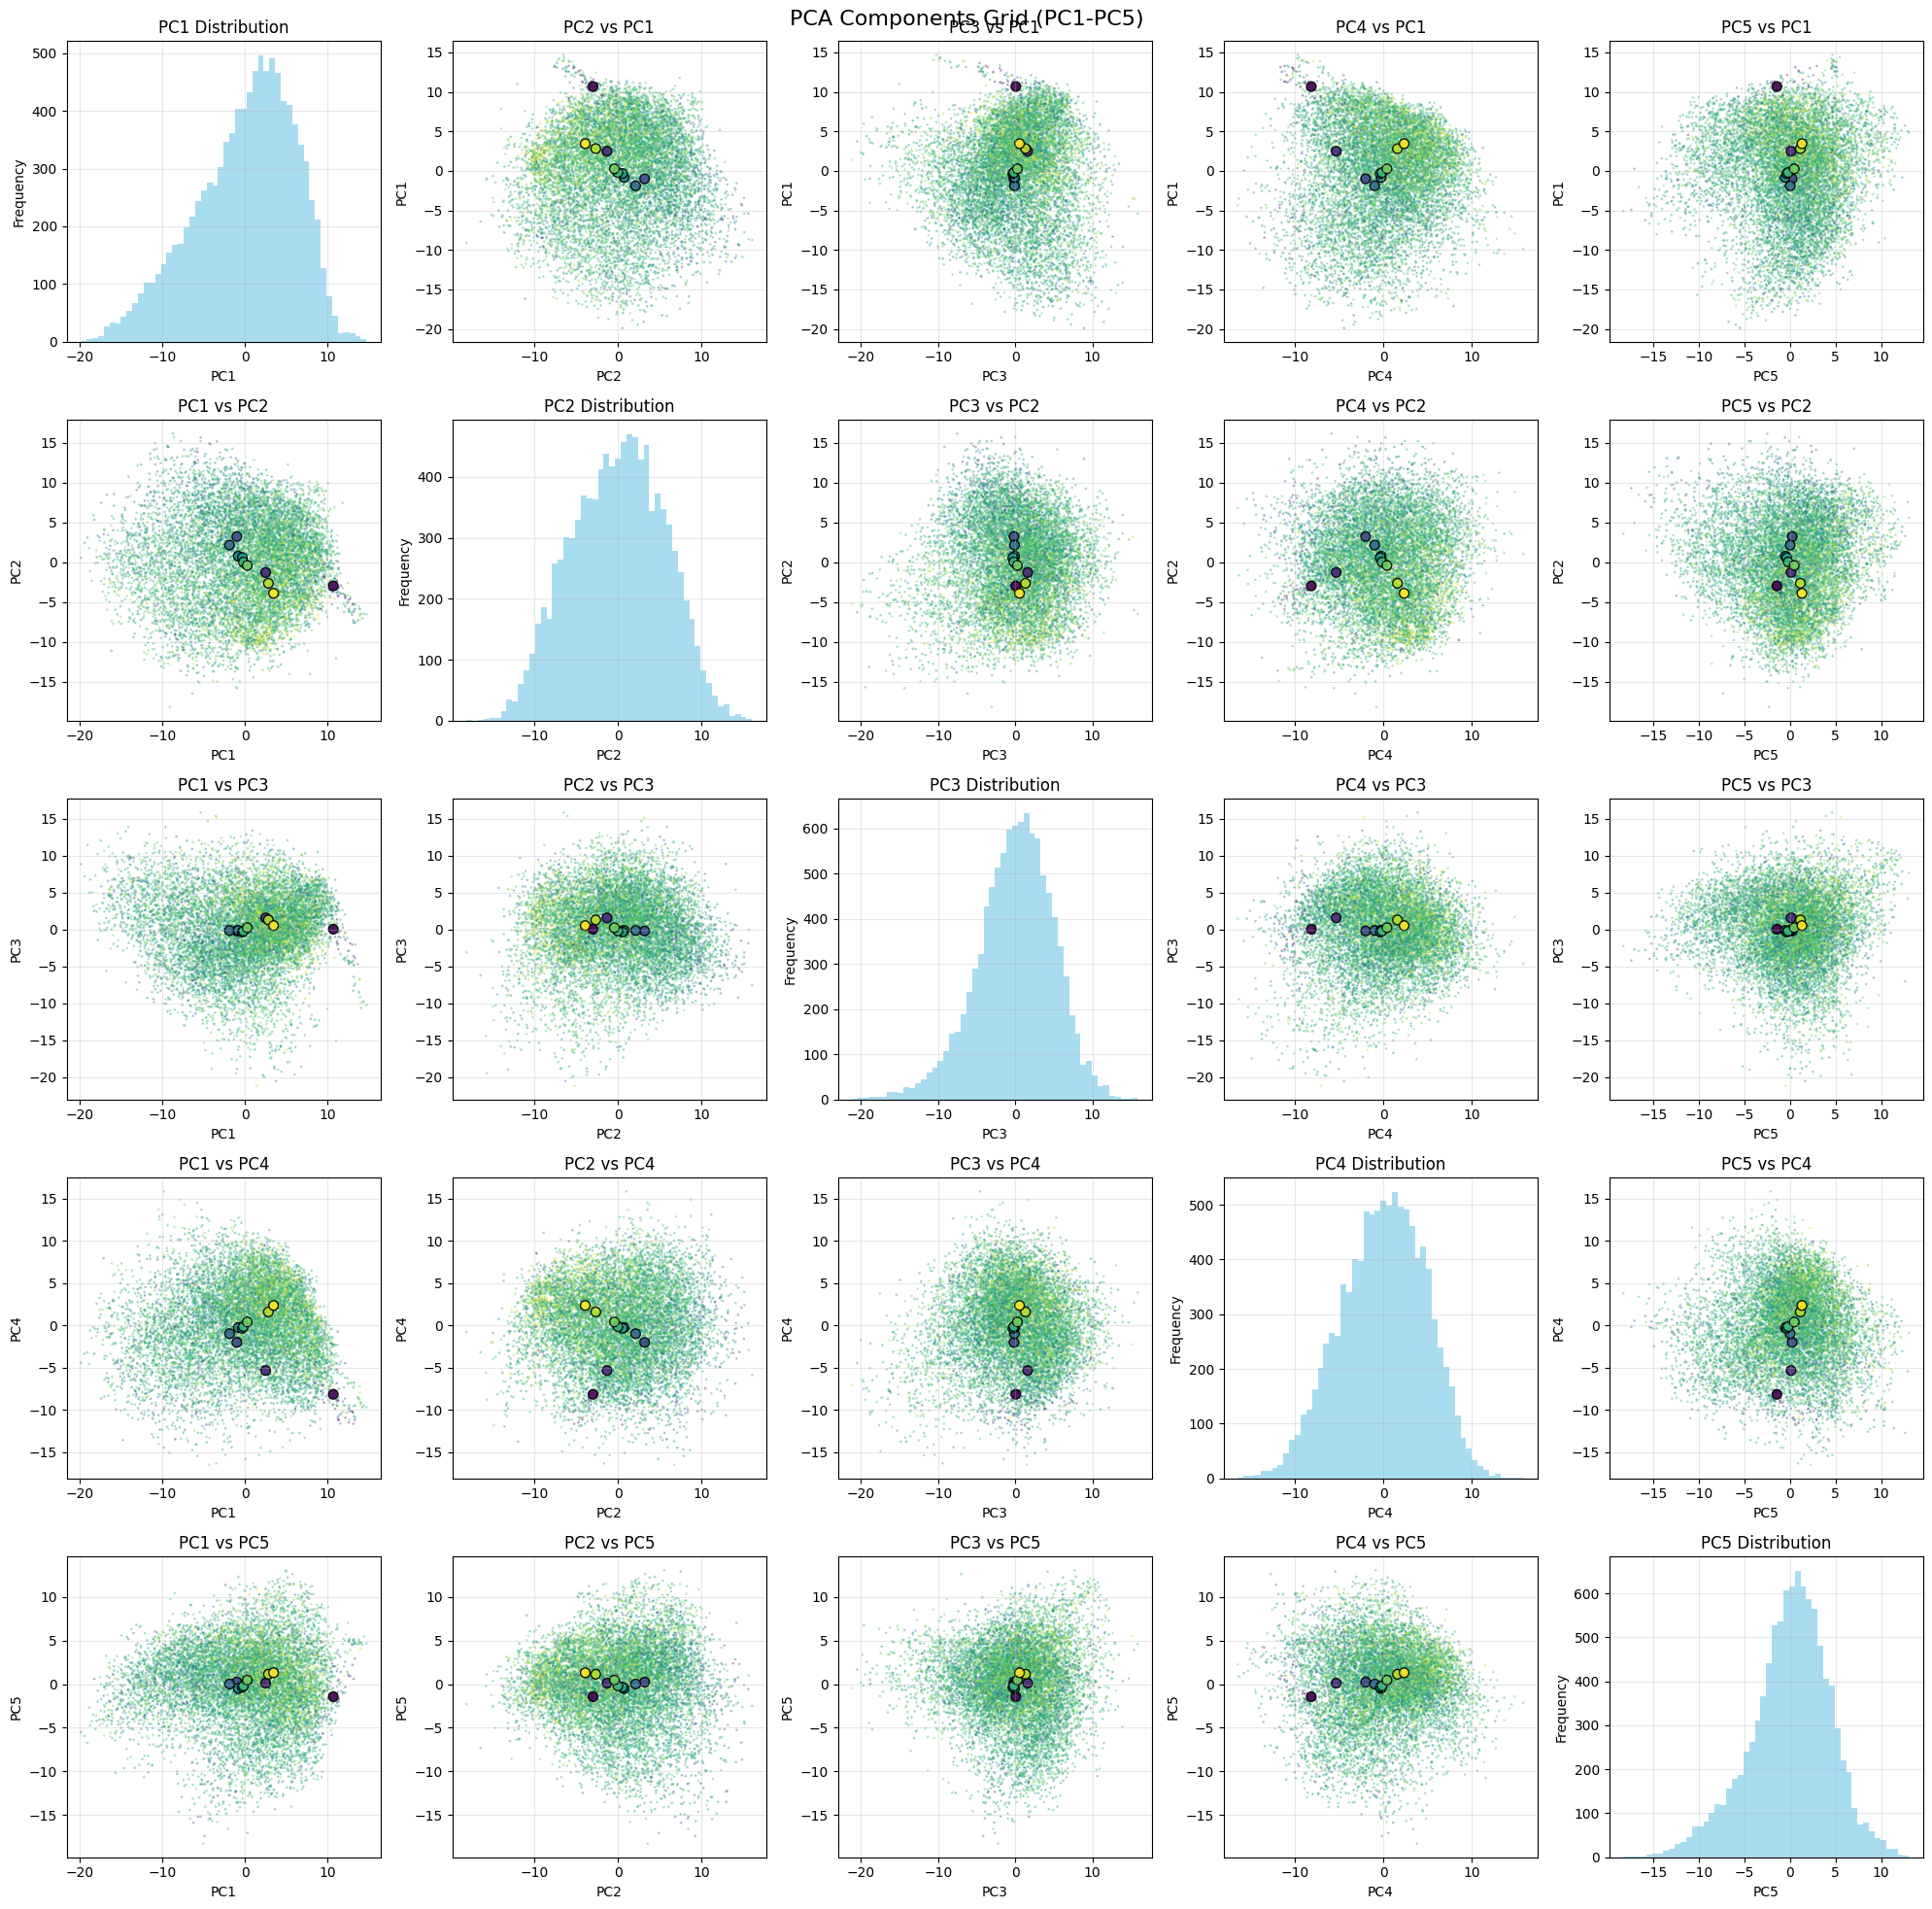

Explained variance ratios for first 5 components:
PC1: 0.0303
PC2: 0.0255
PC3: 0.0205
PC4: 0.0190
PC5: 0.0165
Cumulative explained variance (PC1-PC5): 0.1119


In [36]:
# Create a 5x5 grid of PCA component plots
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
fig.suptitle('PCA Components Grid (PC1-PC5)', fontsize=16)

for i in range(5):
    for j in range(5):
        ax = axes[i, j]
        
        if i == j:
            # Diagonal: show histogram of the component
            component_data = activations_pca[:, i]
            ax.hist(component_data, bins=50, alpha=0.7, color='skyblue')
            ax.set_title(f'PC{i+1} Distribution')
            ax.set_xlabel(f'PC{i+1}')
            ax.set_ylabel('Frequency')
        else:
            # Off-diagonal: scatter plot of two components
            pc1_idx, pc2_idx = j, i  # j for x-axis, i for y-axis
            activations_2d = activations_pca[:, [pc1_idx, pc2_idx]]
            
            # Calculate bin means for this pair
            bin_means = []
            bin_centers = []
            for bin_idx in range(n_bins):
                mask_bin = n_remaining_binned == bin_idx
                if np.sum(mask_bin) > 0:
                    bin_mean = np.mean(activations_2d[mask_bin], axis=0)
                    bin_means.append(bin_mean)
                    bin_centers.append(bin_idx)
            
            bin_means = np.array(bin_means)
            
            # Scatter plot
            scatter = ax.scatter(activations_2d[:, 0], activations_2d[:, 1], 
                               c=n_remaining_binned, cmap='viridis', alpha=0.3, s=1)
            
            # Plot bin means
            if len(bin_means) > 0:
                ax.scatter(bin_means[:, 0], bin_means[:, 1], 
                          c=bin_centers, cmap='viridis', s=50, 
                          edgecolors='black', linewidth=1, alpha=0.9)
            
            ax.set_xlabel(f'PC{pc1_idx+1}')
            ax.set_ylabel(f'PC{pc2_idx+1}')
            ax.set_title(f'PC{pc1_idx+1} vs PC{pc2_idx+1}')
        
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print explained variance for first 5 components
print("Explained variance ratios for first 5 components:")
for i in range(5):
    print(f"PC{i+1}: {pca.explained_variance_ratio_[i]:.4f}")
print(f"Cumulative explained variance (PC1-PC5): {np.sum(pca.explained_variance_ratio_[:5]):.4f}")


In [15]:
# Initialize a tensor of zeros
bin_means = torch.zeros(n_bins)
for bin_idx in range(n_bins):
    mask_bin = n_remaining_binned == bin_idx
    if torch.sum(torch.tensor(mask_bin)) > 0:
        bin_mean = torch.mean(n_remaining_tensor[mask_bin])
        bin_means[bin_idx] = bin_mean
        print(f"Bin {bin_idx}: mean = {bin_mean:.4f}, count = {torch.sum(torch.tensor(mask_bin))}")
    else:
        print(f"Bin {bin_idx}: empty")

print(f"\nOverall bin means: {bin_means}")

Bin 0: mean = 83.5991, count = 18009
Bin 1: mean = 226.2428, count = 9354
Bin 2: mean = 362.2514, count = 12564
Bin 3: mean = 577.1979, count = 15251
Bin 4: mean = 919.1809, count = 16535
Bin 5: mean = 1450.8705, count = 13358
Bin 6: mean = 2256.9172, count = 7449
Bin 7: mean = 3722.8752, count = 3006
Bin 8: mean = 6018.2495, count = 1922
Bin 9: mean = 9578.1807, count = 2065
Bin 10: mean = 13654.2666, count = 839
Bin 11: empty

Overall bin means: tensor([   83.5991,   226.2428,   362.2514,   577.1979,   919.1809,  1450.8705,
         2256.9172,  3722.8752,  6018.2495,  9578.1807, 13654.2666,     0.0000])


In [16]:
# Convert to tensors
n_remaining_binned_tensor = torch.tensor(n_remaining_binned)

# Get bin means in 2560-dimensional space
bin_counts = torch.bincount(n_remaining_binned_tensor, minlength=n_bins)
bin_sums = torch.zeros(n_bins, activations.shape[1])  # Shape: (n_bins, 2560)

# Sum activations for each bin
for i in range(len(activations)):
    bin_idx = n_remaining_binned_tensor[i]
    bin_sums[bin_idx] += activations[i]

# Calculate means (avoid division by zero)
bin_means = torch.zeros_like(bin_sums)
for bin_idx in range(n_bins):
    if bin_counts[bin_idx] > 0:
        bin_means[bin_idx] = bin_sums[bin_idx] / bin_counts[bin_idx]

print(f"Bin means shape: {bin_means.shape}")
print(f"Bin counts: {bin_counts}")

Bin means shape: torch.Size([12, 2560])
Bin counts: tensor([18009,  9354, 12564, 15251, 16535, 13358,  7449,  3006,  1922,  2065,
          839,     0])


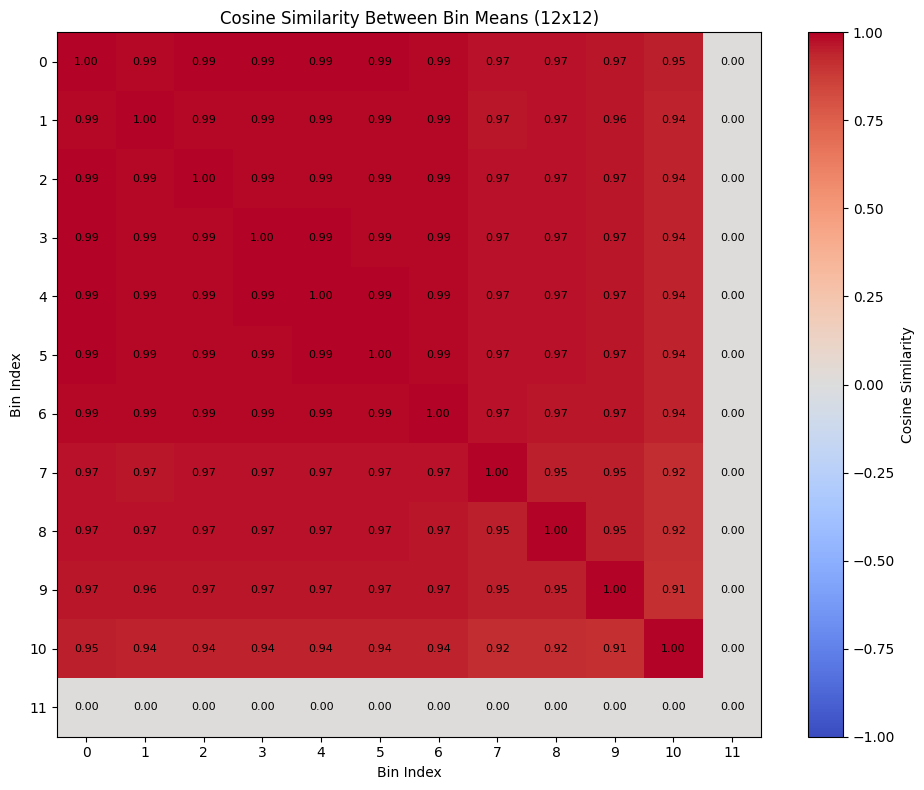

Cosine similarity matrix shape: torch.Size([12, 12])


In [17]:
# Calculate cosine similarity matrix between bin means
from torch.nn.functional import cosine_similarity
import matplotlib.pyplot as plt

# Normalize bin means to unit vectors for cosine similarity
bin_means_normalized = torch.nn.functional.normalize(bin_means, p=2, dim=1)

# Calculate pairwise cosine similarities
cosine_sim_matrix = torch.zeros(n_bins, n_bins)
for i in range(n_bins):
    for j in range(n_bins):
        cosine_sim_matrix[i, j] = cosine_similarity(bin_means_normalized[i:i+1], bin_means_normalized[j:j+1])

# Plot cosine similarity matrix
plt.figure(figsize=(10, 8))
plt.imshow(cosine_sim_matrix.numpy(), cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.title('Cosine Similarity Between Bin Means (12x12)')
plt.xlabel('Bin Index')
plt.ylabel('Bin Index')
plt.xticks(range(n_bins))
plt.yticks(range(n_bins))

# Add text annotations for similarity values
for i in range(n_bins):
    for j in range(n_bins):
        plt.text(j, i, f'{cosine_sim_matrix[i, j]:.2f}', 
                ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

print(f"Cosine similarity matrix shape: {cosine_sim_matrix.shape}")

In [20]:
bin_means.norm(dim=1)

tensor([0.3051, 0.3649, 0.3446, 0.2893, 0.3311, 0.3510, 0.3382, 0.2480, 0.3843,
        0.3268, 0.4048, 0.0000])

In [21]:
bin_counts

tensor([18009,  9354, 12564, 15251, 16535, 13358,  7449,  3006,  1922,  2065,
          839,     0])

In [22]:
mean_bins = torch.zeros(n_bins, activations.shape[1])
count_bins = torch.zeros(n_bins)
for j,(activations, n_remaining, _) in enumerate(train_dataloader):
    n_remaining_binned = bin_y(n_remaining)
    for i,binned in enumerate(n_remaining_binned):
        mean_bins[binned] += activations[i]
        count_bins[binned] += 1
    print(j)
    if j > 100:
        break
    
mean_bins = mean_bins / count_bins.unsqueeze(1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101


In [23]:
mean_bins

tensor([[ 2.5302e+01, -2.3293e+00,  1.4148e-01,  ..., -3.8532e-02,
         -2.0063e-02,  4.8588e-02],
        [ 2.5416e+01, -2.6258e+00, -3.7797e-02,  ..., -4.7337e-03,
         -4.1831e-02,  1.7606e-02],
        [ 2.5459e+01, -2.7282e+00, -1.8461e-02,  ..., -1.1704e-02,
         -4.8542e-02,  1.7759e-02],
        ...,
        [ 2.5020e+01, -3.0311e+00, -6.5782e-02,  ...,  3.3597e-02,
         -2.8779e-04, -4.8230e-02],
        [ 2.5786e+01, -3.5298e+00,  1.5322e-01,  ...,  6.3846e-02,
          7.2365e-02, -3.4147e-02],
        [        nan,         nan,         nan,  ...,         nan,
                 nan,         nan]])

In [24]:
from torch.nn.functional import cosine_similarity

In [25]:
cosine_sims = torch.zeros(n_bins, n_bins)
dot_products = torch.zeros(n_bins, n_bins)
for i in range(n_bins):
    for j in range(n_bins):
        cosine_sims[i,j] = cosine_similarity(mean_bins[i], mean_bins[j], dim=0)
        dot_products[i,j] = torch.dot(mean_bins[i], mean_bins[j])

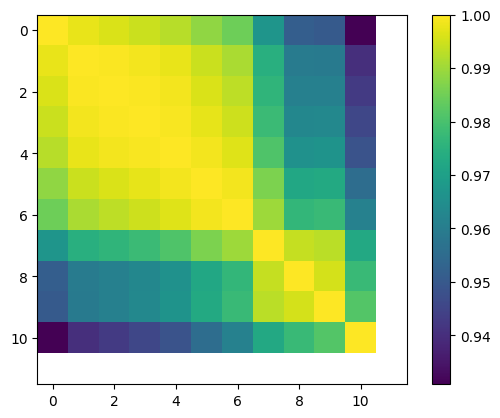

In [26]:
plt.imshow(cosine_sims.numpy())
plt.colorbar()

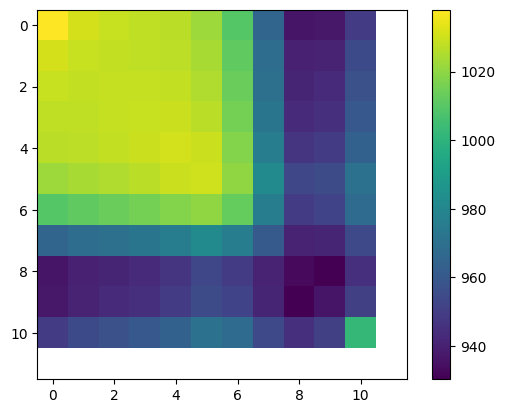

In [27]:
plt.imshow(dot_products.numpy())
plt.colorbar()

In [28]:
mean_bins

tensor([[ 2.5302e+01, -2.3293e+00,  1.4148e-01,  ..., -3.8532e-02,
         -2.0063e-02,  4.8588e-02],
        [ 2.5416e+01, -2.6258e+00, -3.7797e-02,  ..., -4.7337e-03,
         -4.1831e-02,  1.7606e-02],
        [ 2.5459e+01, -2.7282e+00, -1.8461e-02,  ..., -1.1704e-02,
         -4.8542e-02,  1.7759e-02],
        ...,
        [ 2.5020e+01, -3.0311e+00, -6.5782e-02,  ...,  3.3597e-02,
         -2.8779e-04, -4.8230e-02],
        [ 2.5786e+01, -3.5298e+00,  1.5322e-01,  ...,  6.3846e-02,
          7.2365e-02, -3.4147e-02],
        [        nan,         nan,         nan,  ...,         nan,
                 nan,         nan]])

In [112]:
(torch.load('/workspace/llm-progress-monitor/rollouts-big/activations/2.pt')[1].abs() > 5000).sum()

tensor(1)

In [96]:
for i in range(100):
    activations = torch.load('/workspace/llm-progress-monitor/rollouts-big/activations/'+str(i)+'.pt')[1].flatten()
    argmax_idx = torch.argmax(activations)
    max_value = activations[argmax_idx]
    print(f"File {i}: argmax={argmax_idx}, value={max_value}")

File 0: argmax=4, value=16128.0
File 1: argmax=4, value=16128.0
File 2: argmax=4, value=16128.0
File 3: argmax=4, value=16000.0
File 4: argmax=4, value=16000.0
File 5: argmax=4, value=16064.0
File 6: argmax=4, value=16000.0
File 7: argmax=4, value=16000.0
File 8: argmax=4, value=16128.0
File 9: argmax=4, value=16128.0
File 10: argmax=4, value=16000.0
File 11: argmax=4, value=16128.0
File 12: argmax=4, value=16000.0
File 13: argmax=4, value=16000.0
File 14: argmax=4, value=16000.0
File 15: argmax=4, value=16128.0
File 16: argmax=4, value=16000.0
File 17: argmax=4, value=16000.0
File 18: argmax=4, value=16000.0
File 19: argmax=4, value=16000.0
File 20: argmax=4, value=16064.0
File 21: argmax=4, value=16128.0
File 22: argmax=4, value=16000.0
File 23: argmax=4, value=16064.0
File 24: argmax=4, value=16064.0
File 25: argmax=4, value=16128.0
File 26: argmax=4, value=16000.0
File 27: argmax=4, value=16128.0
File 28: argmax=4, value=16000.0
File 29: argmax=4, value=16000.0
File 30: argmax=4, v

In [97]:
activations.dtype

torch.bfloat16

In [33]:
from nnsight import LanguageModel

In [34]:
llm = LanguageModel('Qwen/Qwen3-4B', device_map='cuda')

In [37]:
# Apply chat template and generate tokens
messages = [{"role": "user", "content": "Hello, world!"}, {"role": "assistant", "content": "Hello, world!"}]
chat_input = llm.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)

with llm.generate(chat_input, max_new_tokens=50) as generator:
    print(llm.model.layers[15].output[0].abs()[:,0])

tensor([786.6962,  35.0384,  32.2575,   2.9895,  28.6322,  25.1708,  23.9113,
         21.8750,  28.5003,  14.4567,  24.2988,  21.9099,   8.8433,  17.8624,
          9.6635,  17.2492,  24.0770,  24.2854,  25.0768,  24.2015,  15.1235,
         21.3211], device='cuda:0')


In [114]:
chat_input

'<|im_start|>user\nHello, world!<|im_end|>\n<|im_start|>assistant\n'

In [116]:
chat_input = llm.tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True)

In [117]:
chat_input

[151644, 872, 198, 9707, 11, 1879, 0, 151645, 198, 151644, 77091, 198]

In [119]:
llm.tokenizer.encode('assistant')

[77091]

torch.Size([1024, 2560])
